# Optimize

run and compare optimization frameworks

- hyperopt
- optuna
- nevergrad
- platypus
- scipy (Powell)
- ax


In [1]:
from datetime import datetime
from functools import partial

import pytest
import numpy as np
import pandas as pd
import scipy
# import pandas_datareader as pdr

from SWRsimulation import SWRsimulation

# TODO:
# simulates take override simulation args
# redo history several times without reinitializing with different parameters
# init creates a list of samples, n_trials by n_ret_years
# for history , simulate creates a generator from samples and returns them
# chart - show strategy, fixed, var, stock, add optimizer to title
# chart of all optimizers, do with plotly, hover shows gamma, value, optimizer, elapsed time
# do with deathrate
# multithreading, optimize for speed

print("%s %s" % ('numpy', np.__version__))
print("%s %s" % ('pandas', pd.__version__))
print("%s %s" % ('scipy', scipy.__version__))

numpy 1.19.5
pandas 1.2.1
scipy 1.6.0


In [2]:
N_TRIALS = 1000

In [3]:
def datestr():
    return datetime.strftime(datetime.now(), "%Y-%m-%d %H:%M:%S")


In [4]:
# load Damodaran data from pickle (via http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/histretSP.html )

RETURN_FILE = 'histretSP'
def load_returns():
    return pd.read_pickle('%s.pickle' % RETURN_FILE)

download_df = load_returns()
return_df = download_df.iloc[:, [0, 3, 12]]
return_df.columns=['stocks', 'bonds', 'cpi']

return_df

,stocks,bonds,cpi
Year,,,
1928,0.438112,0.032196,-0.011522
1929,-0.082979,0.030179,0.000000
1930,-0.251236,0.005398,-0.026712
1931,-0.438375,-0.156808,-0.089321
1932,-0.086424,0.235896,-0.103014
...,...,...,...
2016,0.117731,0.103651,0.012616
2017,0.216055,0.097239,0.021301
2018,-0.042269,-0.027626,0.024426


In [5]:
# should adjust CPI to year-ending also but leave it for now
real_return_df = return_df.copy()
# real_return_df.loc[1948:, 'cpi'] = cpi_test['cpi_fred']
# adjust returns for inflation
real_return_df['stocks'] = (1 + real_return_df['stocks']) / (1 + real_return_df['cpi']) - 1
real_return_df['bonds'] = (1 + real_return_df['bonds']) / (1 + real_return_df['cpi']) - 1
real_return_df.drop('cpi', axis=1, inplace=True)
real_return_df.to_pickle('real_return_df.pickle')

real_return_df

,stocks,bonds
Year,,
1928,0.454874,0.044227
1929,-0.082979,0.030179
1930,-0.230686,0.032991
1931,-0.383290,-0.074106
1932,0.018495,0.377832
...,...,...
2016,0.103805,0.089901
2017,0.190692,0.074354
2018,-0.065104,-0.050811


In [6]:
FIXED_SPEND = 2
VARIABLE_SPEND = 2
ALLOC_STOCKS = 0.6
N_RET_YEARS = 30
from functools import partial

def ce_experiment(n_ret_years, gamma, *params):
    # some optimizers pass an array, some pass a dict, some pass indiv unpacked params
    if len(params) == 1:   # unpack
        params = params[0]
        
    if type(params) == dict:
        fixed_spend = params['fixed_spend']
        variable_spend = params['variable_spend']
        alloc_stocks = params['alloc_stocks']
        n_ret_years = N_RET_YEARS
    elif type(params) == list or type(params) == tuple:
        fixed_spend, variable_spend, alloc_stocks = params     
        n_ret_years = N_RET_YEARS
    elif type(params) == np.ndarray:
        fixed_spend, variable_spend, alloc_stocks = params.tolist()
        n_ret_years = N_RET_YEARS
    else:
        raise Exception('bad argument to ce_experiment', type(params), params)
        
    if alloc_stocks > 1.0:
        return 0
    if alloc_stocks < 0.0:
        return 0
    
    alloc_bonds = 1.0 - alloc_stocks

    s = SWRsimulation.SWRsimulation({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': n_ret_years,
#                        'montecarlo': N_TRIALS,
#                        'montecarlo_replacement': False,
                      },
        'allocation': {'asset_weights': np.array([alloc_stocks, alloc_bonds])}, 
        'withdrawal': {'fixed_pct': fixed_spend,
                       'variable_pct': variable_spend},
        'evaluation': {},
        'analysis': {}    
    })
    s.simulate()
    return -SWRsimulation.crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), gamma)

# freeze first 2 args with partial
ce_experiment_1 = partial(ce_experiment, N_RET_YEARS, 1)

# unpacked args
print(ce_experiment_1(FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS))

# list arg
print(ce_experiment_1([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS]))

# ndarray arg
print(ce_experiment_1(np.array([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS])))

# dict arg
print(ce_experiment_1({'fixed_spend': FIXED_SPEND, 
                       'variable_spend': VARIABLE_SPEND, 
                       'alloc_stocks': ALLOC_STOCKS}))



-9519.256017841699
-9519.256017841699
-9519.256017841699
-9519.256017841699


In [7]:
from scipy import optimize
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
# quasi-Newton method
# initial guess
x0 = np.array([0.5, 5.0, 1.0])
method = 'L-BFGS-B'
optimizer = "scipy.optimize (%s)" % method

MAX_ITER = N_TRIALS

study_params = []
study_values = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d iterations" % (datestr(), optimizer, gamma, MAX_ITER))
    start_time = datetime.now()
    
    sobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    fixed_max = 5
    variable_max = 10
    alloc_max = 1

    result = optimize.minimize(sobjective, x0=x0, method=method,
                               options={'maxiter': MAX_ITER},
                               bounds=((0, fixed_max), (0, variable_max), (0, alloc_max))
                              )
    study_params.append(result.x)
    study_values.append(result.fun)

    time_elapsed = datetime.now() - start_time 
    
    print("%s Finishing optimizer %s, gamma %d, %d iterations in %s" % (datestr(), optimizer, gamma, result.nit, time_elapsed))
    print("%s best value %f, best params %s" % (datestr(), result.fun, result.x))



2021-02-09 10:36:40 Starting scipy.optimize (L-BFGS-B), gamma 0, 1000 iterations
2021-02-09 10:36:44 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 0, 5 iterations in 0:00:03.312861
2021-02-09 10:36:44 best value -15532.416056, best params [0.         6.20410436 1.        ]
2021-02-09 10:36:44 Starting scipy.optimize (L-BFGS-B), gamma 1, 1000 iterations
2021-02-09 10:36:47 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 1, 5 iterations in 0:00:03.331962
2021-02-09 10:36:47 best value -14329.303955, best params [0.         6.33137422 1.        ]
2021-02-09 10:36:47 Starting scipy.optimize (L-BFGS-B), gamma 2, 1000 iterations
2021-02-09 10:36:54 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 2, 10 iterations in 0:00:06.673508
2021-02-09 10:36:54 best value -13132.511625, best params [0.         6.49626204 1.        ]
2021-02-09 10:36:54 Starting scipy.optimize (L-BFGS-B), gamma 4, 1000 iterations
2021-02-09 10:37:01 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 4,

In [8]:
results_dict = {}

In [9]:
results = pd.DataFrame(study_params, columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['value'] = study_values
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value']]
results_dict[optimizer] = results.copy()
results

,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value
0,0,1.000000,0.000000,0.000000,6.204104,-15532.416056
1,1,1.000000,0.000000,0.000000,6.331374,-14329.303955
2,2,1.000000,0.000000,0.000000,6.496262,-13132.511625
3,4,1.000000,0.000000,0.000000,6.790925,-11206.793432
4,6,0.775916,0.224084,1.678529,5.958820,-10113.824493
5,8,0.761725,0.238275,2.741288,3.155909,-9755.148796
6,10,0.729424,0.270576,2.726143,3.018257,-9408.861510
7,12,0.716221,0.283779,3.026949,2.447771,-9174.762741
8,14,0.665883,0.334117,1.630291,6.101387,-8698.980749
9,16,0.700356,0.299644,2.974660,2.322801,-8855.534067


In [10]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


-14329.303955197636

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7f8422300ac0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 2.9746595934338638, 'variable_pct': 2.3228010851549543}
mean annual spending over all cohorts 5.62
0.00% of portfolios exhausted by final year


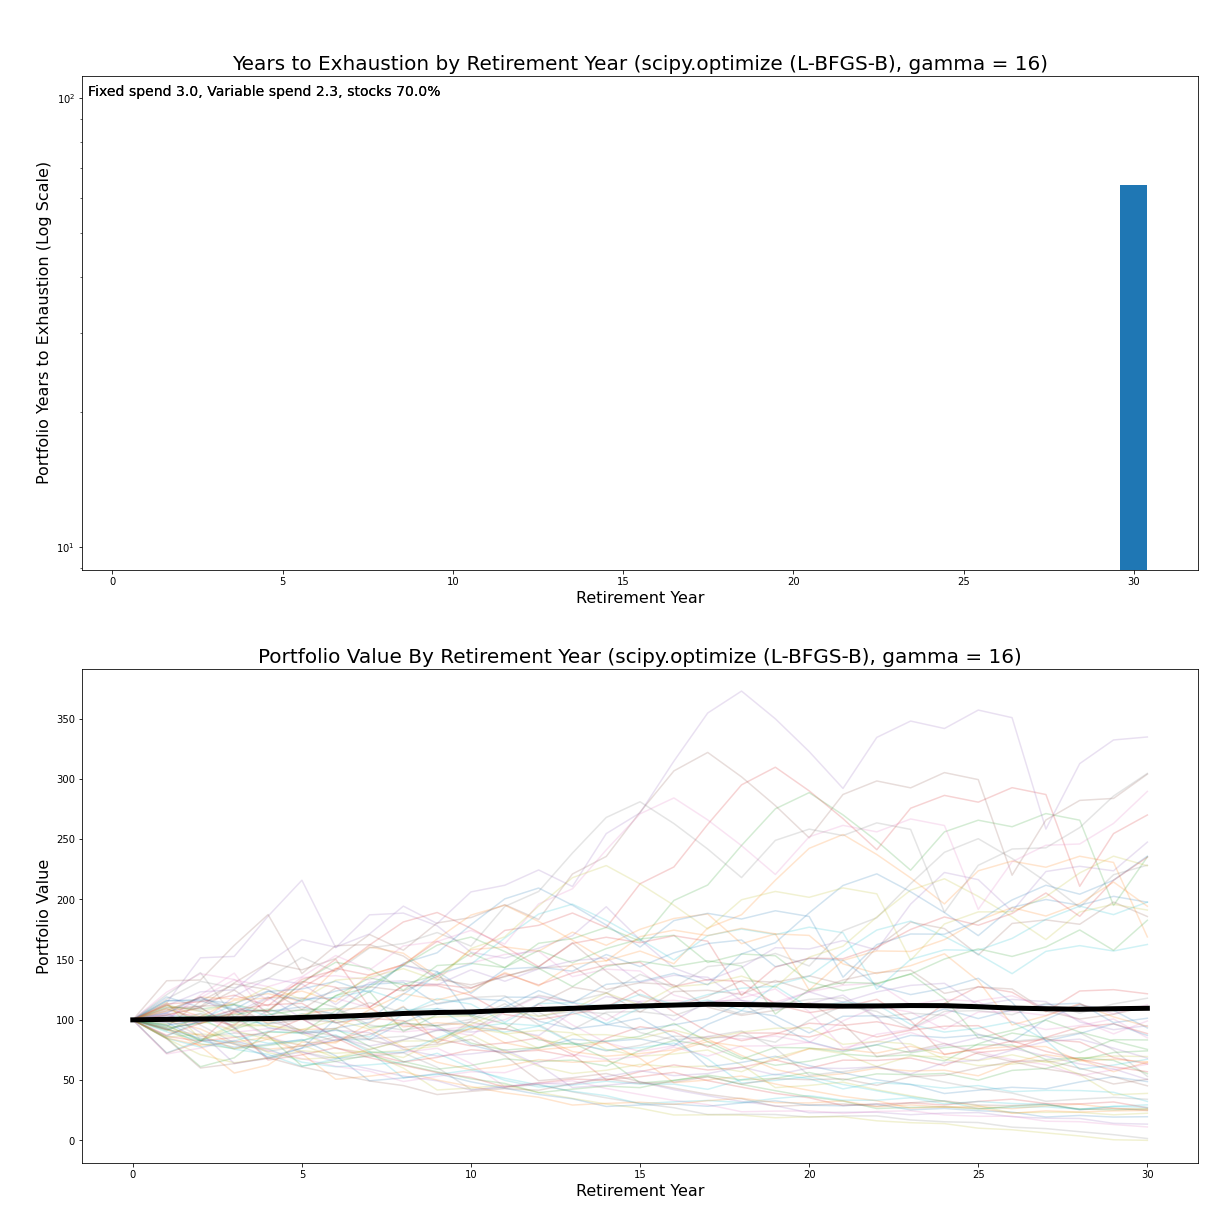

In [11]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True, 
                 'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                 'chart_2' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                }    
})

print(s)

s.simulate()

s.analyze()


In [12]:
import optuna   # https://optuna.org/
print("%s %s" % ('optuna', optuna.__version__))
optuna.logging.set_verbosity(optuna.logging.ERROR)

def objective(gamma, trial):
    fixed_spend = trial.suggest_uniform('fixed_spend', 0, 5)
    variable_spend = trial.suggest_uniform('variable_spend', 0, 10)
    alloc_stocks = trial.suggest_uniform('alloc_stocks', 0, 1)
    oobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    return oobjective([fixed_spend, variable_spend, alloc_stocks])

study_params = []
study_values = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

n_trials = N_TRIALS
optimizer = "Optuna"

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    study = optuna.create_study()
    study.optimize(partial(objective, gamma), n_trials=n_trials)
    study_params.append(study.best_params)
    study_values.append(study.best_value)
    time_elapsed = datetime.now() - start_time 
    
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best value %f, best params %s" % (datestr(), study.best_value, study.best_params))
    

optuna 2.5.0
2021-02-09 10:40:26 Starting Optuna, gamma 0, 1000 trials
2021-02-09 10:42:32 Finishing optimizer Optuna, gamma 0, 1000 trials in 0:02:06.613319
2021-02-09 10:42:32 best value -15531.648237, best params {'fixed_spend': 0.0007780515413637298, 'variable_spend': 6.165609040019555, 'alloc_stocks': 0.9999668279821835}
2021-02-09 10:42:32 Starting Optuna, gamma 1, 1000 trials
2021-02-09 10:44:39 Finishing optimizer Optuna, gamma 1, 1000 trials in 0:02:06.921126
2021-02-09 10:44:39 best value -14328.112217, best params {'fixed_spend': 0.0027393394701196536, 'variable_spend': 6.3605604806539375, 'alloc_stocks': 0.9999353219438275}
2021-02-09 10:44:39 Starting Optuna, gamma 2, 1000 trials
2021-02-09 10:46:46 Finishing optimizer Optuna, gamma 2, 1000 trials in 0:02:06.951613
2021-02-09 10:46:46 best value -13132.374657, best params {'fixed_spend': 5.038245356889866e-05, 'variable_spend': 6.471661940570409, 'alloc_stocks': 0.9999858194433917}
2021-02-09 10:46:46 Starting Optuna, gamm

In [13]:
results = pd.DataFrame(study_params)
results['gamma'] = study_gammas
results['value'] = study_values
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value']]
results_dict[optimizer] = results.copy()
results

,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value
0,0,0.999967,0.000033,0.000778,6.165609,-15531.648237
1,1,0.999935,0.000065,0.002739,6.360560,-14328.112217
2,2,0.999986,0.000014,0.000050,6.471662,-13132.374657
3,4,0.939784,0.060216,2.123855,4.528672,-11148.828741
4,6,0.820573,0.179427,2.585221,3.561126,-10265.139037
5,8,0.752885,0.247115,2.769378,3.084710,-9754.385479
6,10,0.733845,0.266155,2.873611,2.825014,-9417.177423
7,12,0.711491,0.288509,3.034914,2.435405,-9174.674704
8,14,0.713015,0.286985,2.920830,2.497363,-8992.437983
9,16,0.705372,0.294628,2.995701,2.276879,-8855.400594


In [14]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


-14328.112216918087

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7f840dce8270>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 2.9957005811831303, 'variable_pct': 2.2768790015308484}
mean annual spending over all cohorts 5.60
0.00% of portfolios exhausted by final year


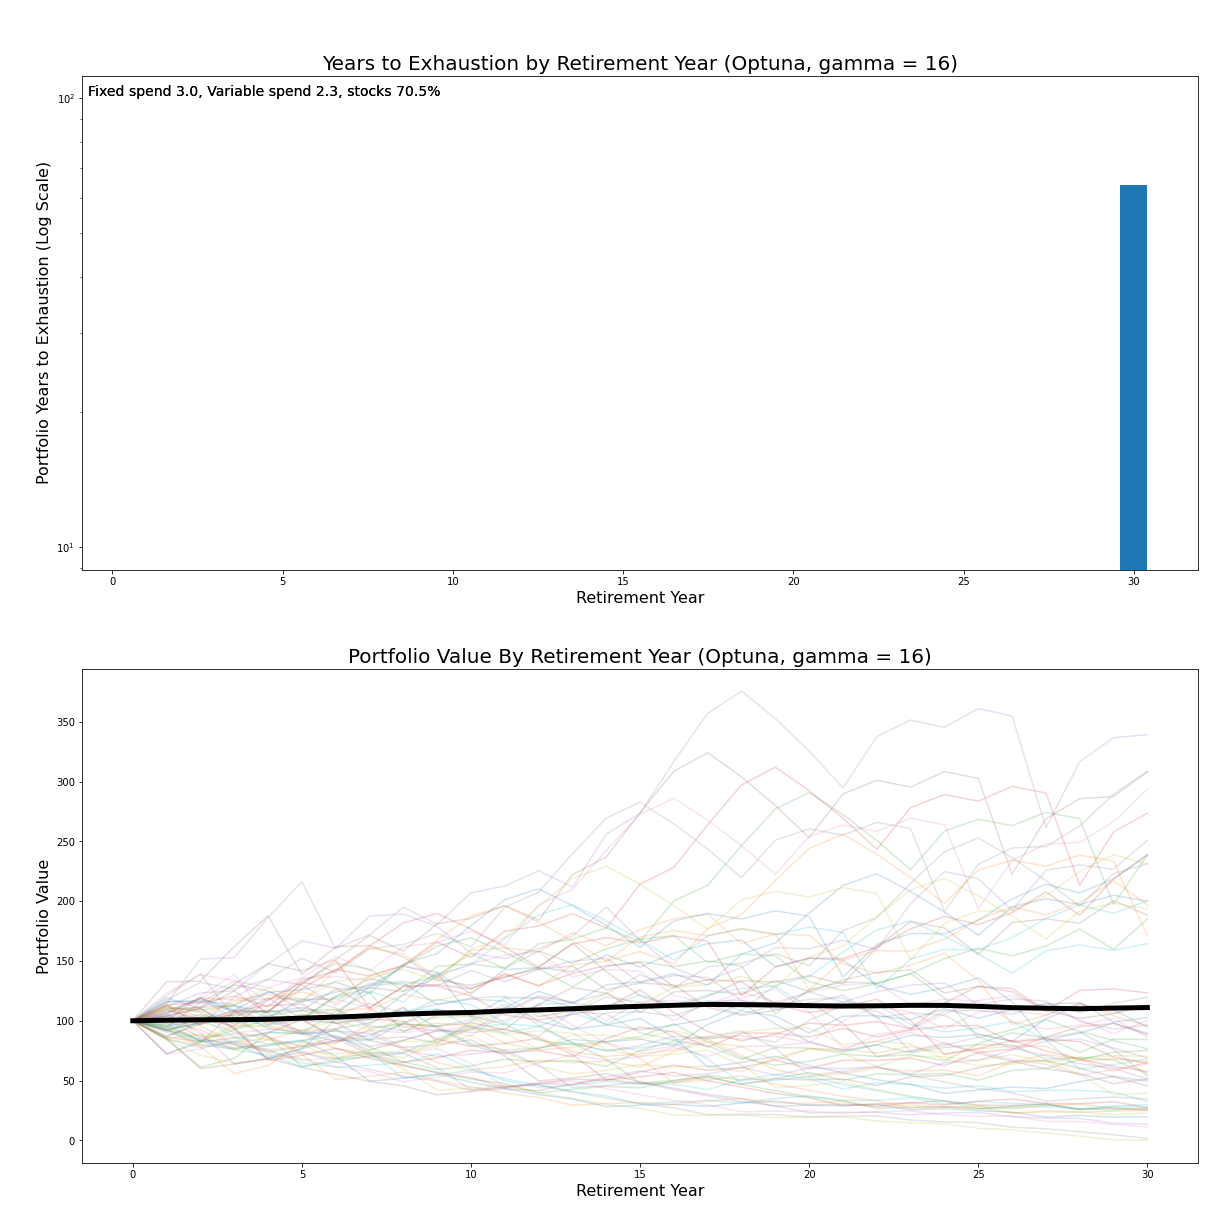

In [15]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True, 
                 'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                 'chart_2' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                }    
})

print(s)

s.simulate()

s.analyze()

In [16]:
import hyperopt  # http://hyperopt.github.io/hyperopt/
from hyperopt import fmin, tpe, hp
print("%s %s" % ('hyperopt', hyperopt.__version__))

n_trials = N_TRIALS
optimizer = "Hyperopt"

study_params = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]
for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    hobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    best = fmin(fn=hobjective,
                space={'fixed_spend': hp.uniform('fixed_spend', 0, 5),
                       'variable_spend': hp.uniform('variable_spend', 0, 10),
                       'alloc_stocks': hp.uniform('alloc_stocks', 0, 1),
                      },
                algo=tpe.suggest,
                max_evals=n_trials)
    study_params.append(best)
    time_elapsed = datetime.now() - start_time 
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s" % (datestr(), study.best_params))
        

hyperopt 0.2.5
2021-02-09 11:01:36 Starting Hyperopt, gamma 0, 1000 trials
100%|██████████| 1000/1000 [02:11<00:00,  7.62trial/s, best loss: -15518.156158039415]
2021-02-09 11:03:47 Finishing optimizer Hyperopt, gamma 0, 1000 trials in 0:02:11.218234
2021-02-09 11:03:47 best params {'fixed_spend': 2.9957005811831303, 'variable_spend': 2.2768790015308484, 'alloc_stocks': 0.7053716465133192}
2021-02-09 11:03:47 Starting Hyperopt, gamma 1, 1000 trials
100%|██████████| 1000/1000 [02:11<00:00,  7.59trial/s, best loss: -14323.724677641445]
2021-02-09 11:05:59 Finishing optimizer Hyperopt, gamma 1, 1000 trials in 0:02:11.733979
2021-02-09 11:05:59 best params {'fixed_spend': 2.9957005811831303, 'variable_spend': 2.2768790015308484, 'alloc_stocks': 0.7053716465133192}
2021-02-09 11:05:59 Starting Hyperopt, gamma 2, 1000 trials
100%|██████████| 1000/1000 [02:12<00:00,  7.57trial/s, best loss: -13130.824483152272]
2021-02-09 11:08:11 Finishing optimizer Hyperopt, gamma 2, 1000 trials in 0:02:12.

In [17]:
results = pd.DataFrame(study_params)
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend']]
study_values = []
for t in results.itertuples():
    hobjective = partial(ce_experiment, N_RET_YEARS, t.gamma)
    study_values.append(hobjective({'fixed_spend': t.fixed_spend, 
                                    'variable_spend': t.variable_spend, 
                                    'alloc_stocks': t.alloc_stocks, 
                                   }))
results['value'] = study_values
results_dict[optimizer] = results.copy()
results

,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value
0,0,0.998763,0.001237,0.005081,6.152245,-15518.156158
1,1,0.999998,0.000002,0.006466,6.154059,-14323.724678
2,2,0.999874,0.000126,0.006224,6.495247,-13130.824483
3,4,0.999782,0.000218,0.003129,6.739488,-11206.003988
4,6,0.832178,0.167822,2.611457,3.476104,-10261.550488
5,8,0.758125,0.241875,2.871443,2.940116,-9747.991425
6,10,0.741518,0.258482,2.974843,2.631726,-9413.765932
7,12,0.718755,0.281245,2.978199,2.578329,-9173.571450
8,14,0.692190,0.307810,2.942045,2.411702,-8991.488297
9,16,0.721079,0.278921,3.210323,1.910499,-8849.525508


In [18]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


-14323.724677641445

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7f840dce8ac0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 3.210322866394687, 'variable_pct': 1.9104994984359303}
mean annual spending over all cohorts 5.47
1.56% of portfolios exhausted by final year


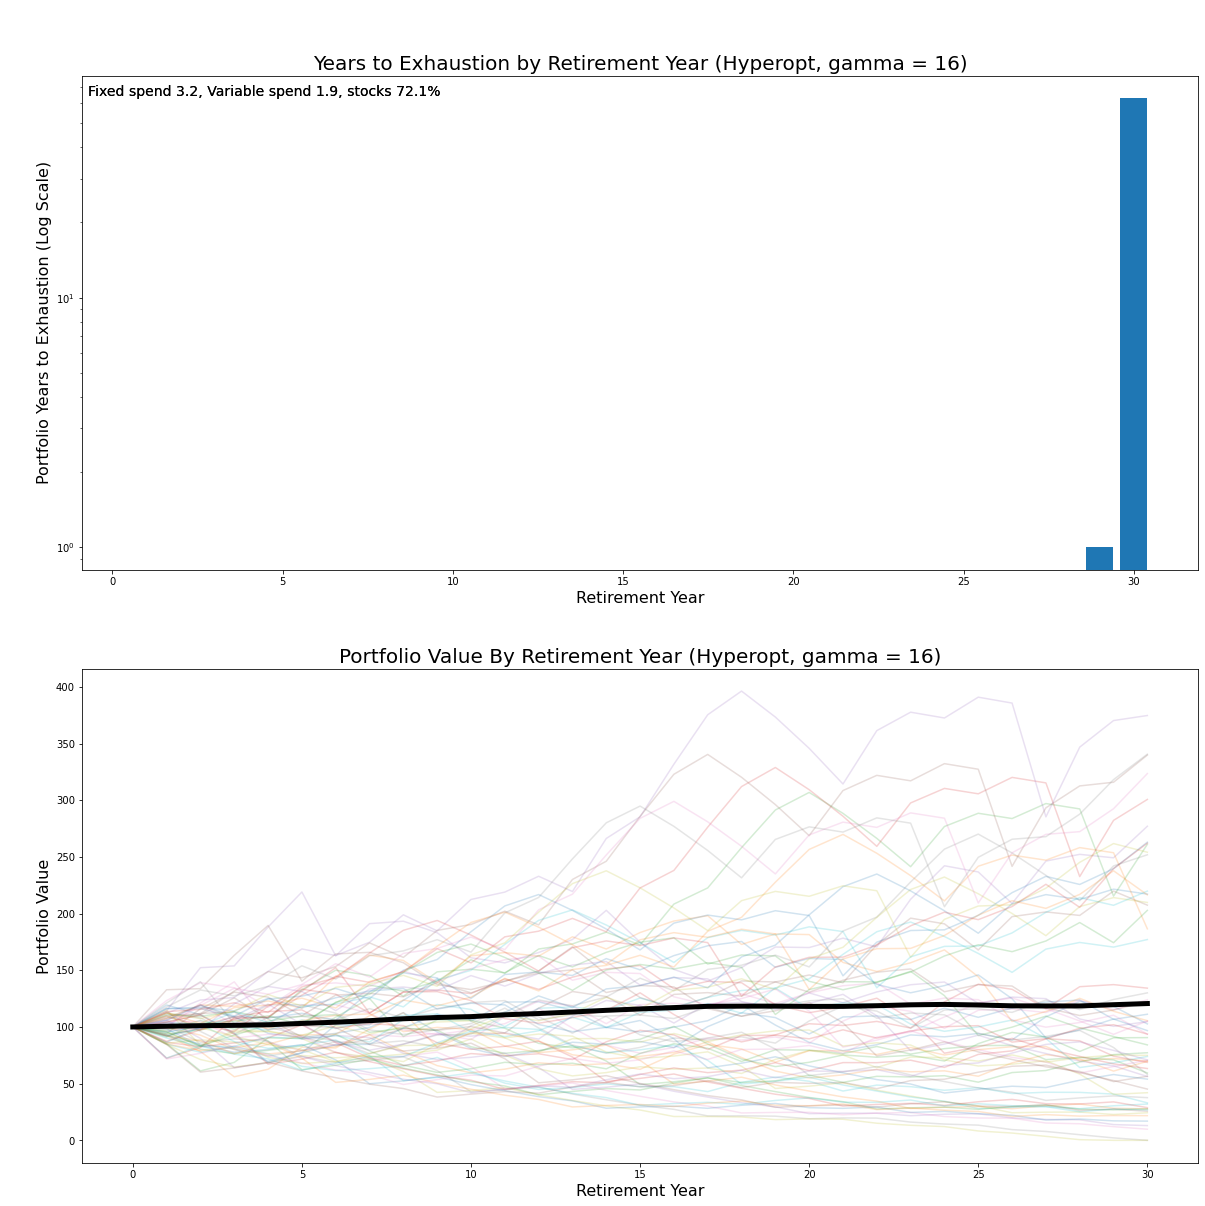

In [19]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True, 
                 'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                 'chart_2' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                }    
})

print(s)

s.simulate()
s.analyze()

In [20]:
# https://github.com/Project-Platypus/Platypus
import platypus
from platypus import MOEAD, Problem, Real
print("%s %s" % ("platypus", platypus.__version__))
n_trials = N_TRIALS
optimizer = "Platypus (MOEAD)"

study_params = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    # number inputs, outputs
    problem = Problem(3, 1)
    # ranges
    problem.types[0] = Real(0, 5)   # fixed_spend
    problem.types[1] = Real(0, 10)  # variable_spend
    problem.types[2] = Real(0, 1)   # alloc_stocks

    # platypus wants a numpy array return because it's a multi-objective algo
    f = partial(ce_experiment, N_RET_YEARS, gamma)
    def pobjective(params):
        return np.array([f(params)])

    problem.function = pobjective
    algorithm = MOEAD(problem)
    algorithm.run(n_trials)
    best = sorted([(s.objectives[0], s.variables) for s in algorithm.result if s.feasible])[0]
    # tuple of best objective value, best params
    study_params.append(best)
    time_elapsed = datetime.now() - start_time 
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s" % (datestr(), best))


platypus 1.0.4
2021-02-09 11:23:31 Starting Platypus (MOEAD), gamma 0, 1000 trials
2021-02-09 11:25:51 Finishing optimizer Platypus (MOEAD), gamma 0, 1000 trials in 0:02:19.832365
2021-02-09 11:25:51 best params (-15530.075661942756, [0.0030602941102437775, 6.117071026293139, 0.9999621484615474])
2021-02-09 11:25:51 Starting Platypus (MOEAD), gamma 1, 1000 trials
2021-02-09 11:28:10 Finishing optimizer Platypus (MOEAD), gamma 1, 1000 trials in 0:02:18.745482
2021-02-09 11:28:10 best params (-14321.618478288436, [0.007847716634999946, 6.364536833759192, 0.9991804394388701])
2021-02-09 11:28:10 Starting Platypus (MOEAD), gamma 2, 1000 trials
2021-02-09 11:30:28 Finishing optimizer Platypus (MOEAD), gamma 2, 1000 trials in 0:02:18.343748
2021-02-09 11:30:28 best params (-13132.056909579602, [0.0015226086626522368, 6.482124074901132, 0.9999637158686879])
2021-02-09 11:30:28 Starting Platypus (MOEAD), gamma 4, 1000 trials
2021-02-09 11:32:45 Finishing optimizer Platypus (MOEAD), gamma 4, 10

In [21]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend']]
results['value'] = [s[0] for s in study_params]
results_dict[optimizer] = results.copy()
results

,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value
0,0,0.999962,0.000038,0.003060,6.117071,-15530.075662
1,1,0.999180,0.000820,0.007848,6.364537,-14321.618478
2,2,0.999964,0.000036,0.001523,6.482124,-13132.056910
3,4,0.933910,0.066090,2.156670,4.444299,-11150.294787
4,6,0.799683,0.200317,2.496260,3.758837,-10263.484688
5,8,0.753929,0.246071,2.515604,3.660847,-9744.861875
6,10,0.726910,0.273090,2.777981,3.040308,-9414.406425
7,12,0.721158,0.278842,3.022908,2.390376,-9172.168868
8,14,0.703994,0.296006,3.095779,2.226092,-8992.316418
9,16,0.706332,0.293668,3.037519,2.190398,-8854.864389


In [22]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


-14321.618478288436

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7f840cf0bf90>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 3.0375188109391686, 'variable_pct': 2.1903979557926148}
mean annual spending over all cohorts 5.57
0.00% of portfolios exhausted by final year


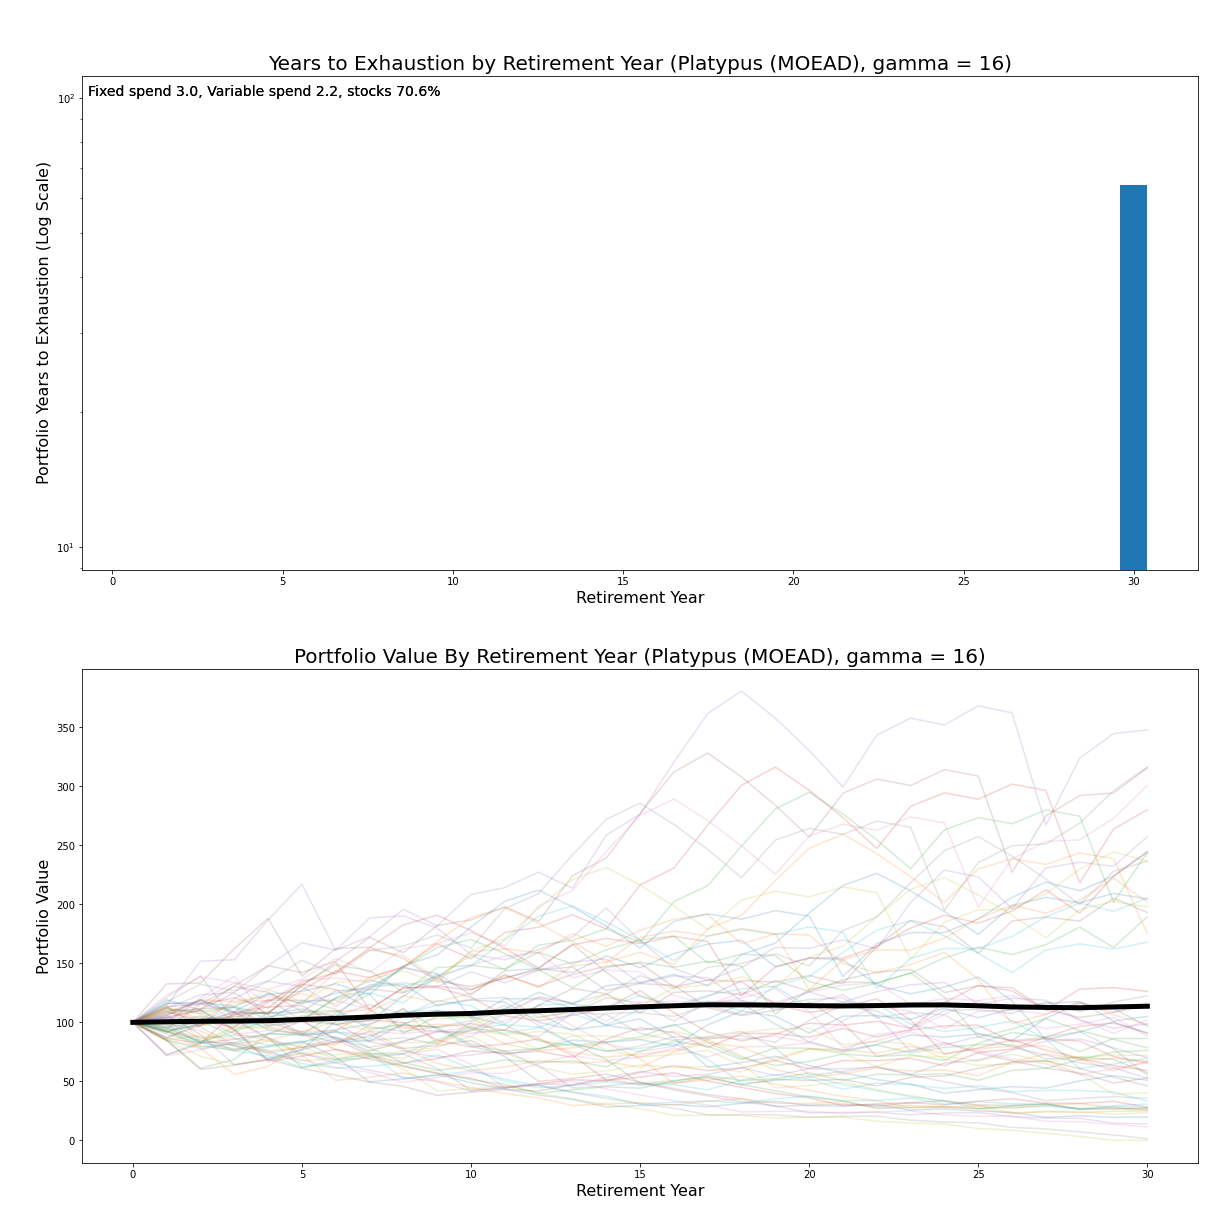

In [23]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True, 
                 'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                 'chart_2' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                }    
})

print(s)

s.simulate()
s.analyze()

In [27]:
import nevergrad as ng  # https://facebookresearch.github.io/nevergrad/optimization.html
print("%s %s" % ("nevergrad", ng.__version__))

from concurrent import futures

n_trials = N_TRIALS
optimizer = "Nevergrad (OnePlusOne)"

study_params = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    nobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    opt = ng.optimizers.OnePlusOne(parametrization=3, budget=n_trials, num_workers=10)

    opt.parametrization.register_cheap_constraint(lambda x: x[0] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[0] <= 5)
    opt.parametrization.register_cheap_constraint(lambda x: x[1] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[1] <= 10)
    opt.parametrization.register_cheap_constraint(lambda x: x[2] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[2] <= 1)
    with futures.ThreadPoolExecutor(max_workers=opt.num_workers) as executor:
        recommendation = opt.minimize(nobjective, executor=executor, batch_mode=False)
    
    time_elapsed = datetime.now() - start_time 
    study_params.append((recommendation.loss, recommendation.value.tolist()))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s value %f" % (datestr(), recommendation.value, recommendation.loss))
        


nevergrad 0.4.3
2021-02-09 11:46:38 Starting Nevergrad (OnePlusOne), gamma 0, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/

2021-02-09 11:49:51 Finishing optimizer Nevergrad (OnePlusOne), gamma 0, 1000 trials in 0:03:13.534150
2021-02-09 11:49:51 best params [2.90350906 4.15170318 1.        ] value -14742.229931
2021-02-09 11:49:51 Starting Nevergrad (OnePlusOne), gamma 1, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(


2021-02-09 11:53:17 Finishing optimizer Nevergrad (OnePlusOne), gamma 1, 1000 trials in 0:03:26.222313
2021-02-09 11:53:17 best params [3.66595491 2.97155453 0.99999952] value -13039.022851
2021-02-09 11:53:17 Starting Nevergrad (OnePlusOne), gamma 2, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/

2021-02-09 11:56:41 Finishing optimizer Nevergrad (OnePlusOne), gamma 2, 1000 trials in 0:03:23.503758
2021-02-09 11:56:41 best params [0.79348151 6.26660258 1.        ] value -12990.331816
2021-02-09 11:56:41 Starting Nevergrad (OnePlusOne), gamma 4, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")


2021-02-09 12:00:04 Finishing optimizer Nevergrad (OnePlusOne), gamma 4, 1000 trials in 0:03:23.044124
2021-02-09 12:00:04 best params [0.47149441 6.19631366 1.        ] value -11143.400854
2021-02-09 12:00:04 Starting Nevergrad (OnePlusOne), gamma 6, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")


2021-02-09 12:03:37 Finishing optimizer Nevergrad (OnePlusOne), gamma 6, 1000 trials in 0:03:32.799669
2021-02-09 12:03:37 best params [2.50872207 3.71584384 0.80653614] value -10263.471100
2021-02-09 12:03:37 Starting Nevergrad (OnePlusOne), gamma 8, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(


2021-02-09 12:07:04 Finishing optimizer Nevergrad (OnePlusOne), gamma 8, 1000 trials in 0:03:27.188950
2021-02-09 12:07:04 best params [2.28268437 4.08849848 0.74972602] value -9729.947511
2021-02-09 12:07:04 Starting Nevergrad (OnePlusOne), gamma 10, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/

2021-02-09 12:14:10 Finishing optimizer Nevergrad (OnePlusOne), gamma 12, 1000 trials in 0:03:35.237999
2021-02-09 12:14:10 best params [2.08110873 4.6581152  0.69766783] value -9068.024383
2021-02-09 12:14:10 Starting Nevergrad (OnePlusOne), gamma 14, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/

2021-02-09 12:17:37 Finishing optimizer Nevergrad (OnePlusOne), gamma 14, 1000 trials in 0:03:26.388858
2021-02-09 12:17:37 best params [2.63933277 3.13129008 0.69631062] value -8980.211921
2021-02-09 12:17:37 Starting Nevergrad (OnePlusOne), gamma 16, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/

2021-02-09 12:21:07 Finishing optimizer Nevergrad (OnePlusOne), gamma 16, 1000 trials in 0:03:30.244246
2021-02-09 12:21:07 best params [3.20805501 1.94324526 0.70716115] value -8850.907440


In [28]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend']]
results['value'] = [s[0] for s in study_params]
results_dict[optimizer] = results.copy()
results


,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value
0,0,1.000000,1.110223e-16,2.903509,4.151703,-14742.229931
1,1,1.000000,4.847891e-07,3.665955,2.971555,-13039.022851
2,2,1.000000,4.440892e-16,0.793482,6.266603,-12990.331816
3,4,1.000000,6.417089e-14,0.471494,6.196314,-11143.400854
4,6,0.806536,1.934639e-01,2.508722,3.715844,-10263.471100
5,8,0.749726,2.502740e-01,2.282684,4.088498,-9729.947511
6,10,0.701223,2.987771e-01,1.852736,5.364125,-9264.243838
7,12,0.697668,3.023322e-01,2.081109,4.658115,-9068.024383
8,14,0.696311,3.036894e-01,2.639333,3.131290,-8980.211921
9,16,0.707161,2.928389e-01,3.208055,1.943245,-8850.907440


In [29]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


-13039.022850780339

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7f840cf02430>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 3.2080550132376966, 'variable_pct': 1.9432452622396128}
mean annual spending over all cohorts 5.49
1.56% of portfolios exhausted by final year


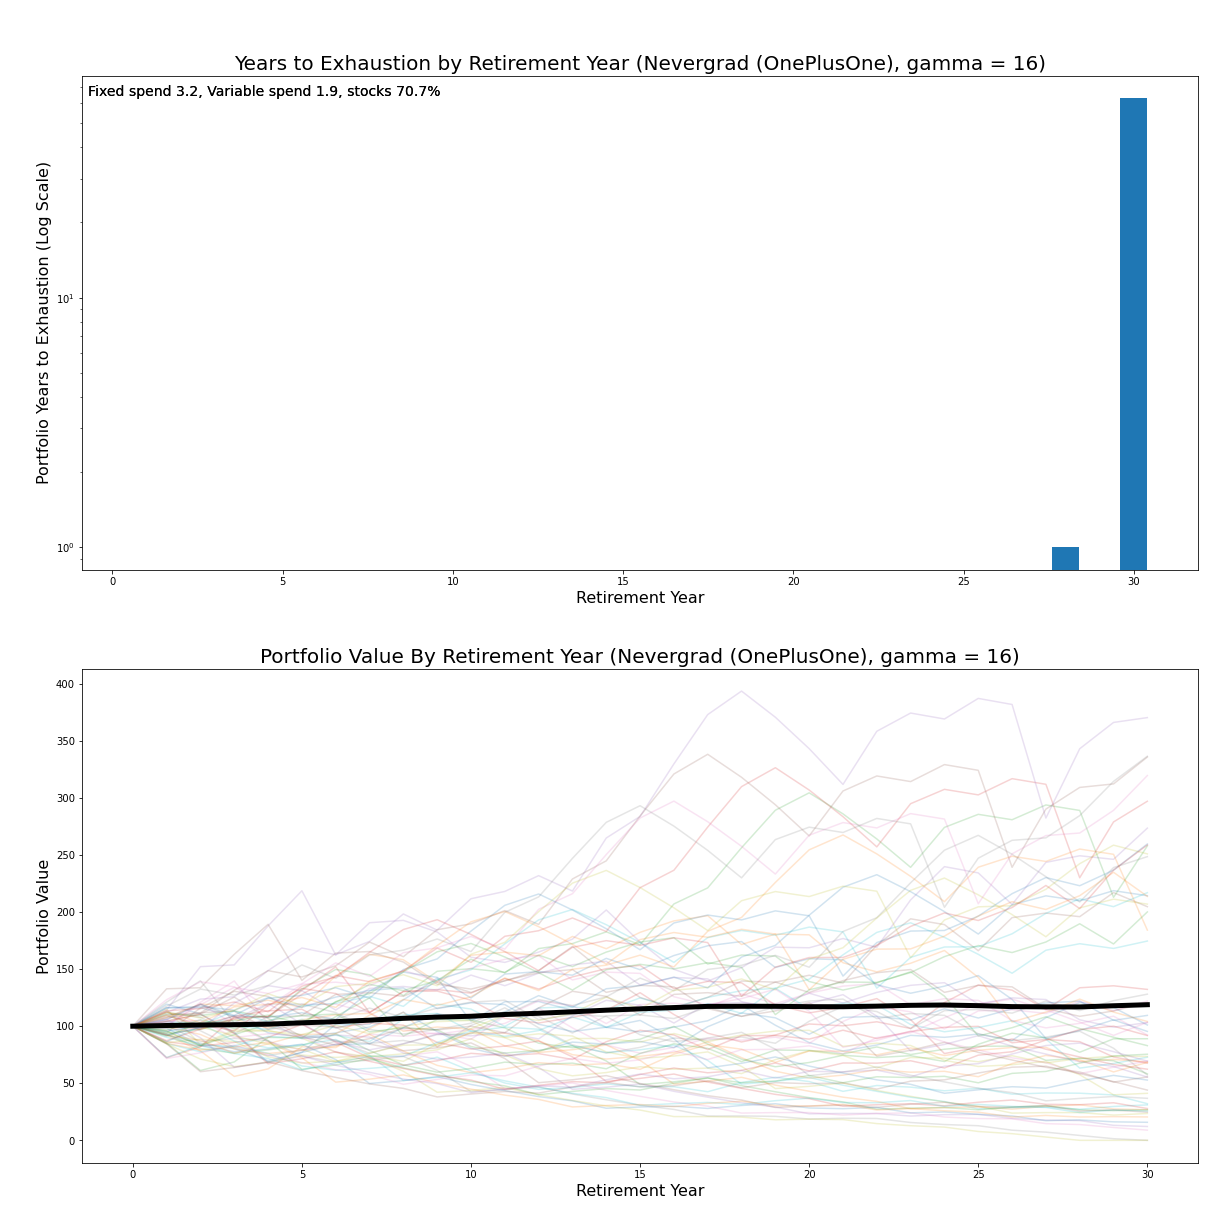

In [30]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True, 
                 'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                 'chart_2' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                }    
})

print(s)

s.simulate()
s.analyze()

In [31]:
import ax  # https://ax.dev/
print("%s %s" % ("ax", ax.__version__))

n_trials = N_TRIALS // 10  # otherwise very slow
optimizer = "Ax (defaults)"

study_params = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    aobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    
    best_parameters, best_values, experiment, model = ax.optimize(
        parameters=[
            {
                "name": "fixed_spend",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 5.0],
            },
            {
                "name": "variable_spend",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 10.0],
            },
            {
                "name": "alloc_stocks",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 1.0],
            },
        ],
        evaluation_function=aobjective,
        minimize=True,
        total_trials=n_trials,
        #verbose_logging=False
    )
    
    time_elapsed = datetime.now() - start_time 
    
    study_params.append((best_values[0]['objective'], 
                         [best_parameters['fixed_spend'], 
                          best_parameters['variable_spend'], 
                          best_parameters['alloc_stocks']]
                        ))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s value %s" % (datestr(), best_values[0]['objective'], best_parameters))


[INFO 02-09 12:21:08] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 02-09 12:21:08] ax.service.managed_loop: Started full optimization with 100 steps.
[INFO 02-09 12:21:08] ax.service.managed_loop: Running optimization trial 1...
[INFO 02-09 12:21:08] ax.service.managed_loop: Running optimization trial 2...


ax 0.1.19
2021-02-09 12:21:08 Starting Ax (defaults), gamma 0, 100 trials


[INFO 02-09 12:21:09] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-09 12:21:09] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-09 12:21:09] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-09 12:21:09] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-09 12:21:09] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-09 12:21:10] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-09 12:21:11] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-09 12:21:11] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-09 12:21:12] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-09 12:21:12] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-09 12:21:13] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-09 12:21:13] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-09 12:21:14] ax.service.managed_loop: 

[INFO 02-09 12:21:45] ax.service.managed_loop: Running optimization trial 2...


2021-02-09 12:21:44 Finishing optimizer Ax (defaults), gamma 0, 100 trials in 0:00:36.146324
2021-02-09 12:21:44 best params -15531.711246368704 value {'fixed_spend': 1.6763222994980071e-07, 'variable_spend': 6.272533387495684, 'alloc_stocks': 0.9999999996602013}
2021-02-09 12:21:44 Starting Ax (defaults), gamma 1, 100 trials


[INFO 02-09 12:21:45] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-09 12:21:45] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-09 12:21:45] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-09 12:21:45] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-09 12:21:45] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-09 12:21:46] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-09 12:21:46] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-09 12:21:47] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-09 12:21:47] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-09 12:21:48] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-09 12:21:48] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-09 12:21:49] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-09 12:21:49] ax.service.managed_loop: 

[INFO 02-09 12:22:19] ax.service.managed_loop: Running optimization trial 2...


2021-02-09 12:22:19 Finishing optimizer Ax (defaults), gamma 1, 100 trials in 0:00:34.822937
2021-02-09 12:22:19 best params -14329.285952616454 value {'fixed_spend': 1.6711147429232594e-15, 'variable_spend': 6.331593892904259, 'alloc_stocks': 1.0}
2021-02-09 12:22:19 Starting Ax (defaults), gamma 2, 100 trials


[INFO 02-09 12:22:20] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-09 12:22:20] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-09 12:22:20] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-09 12:22:20] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-09 12:22:20] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-09 12:22:21] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-09 12:22:21] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-09 12:22:22] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-09 12:22:22] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-09 12:22:23] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-09 12:22:23] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-09 12:22:24] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-09 12:22:24] ax.service.managed_loop: 

2021-02-09 12:22:27 Finishing optimizer Ax (defaults), gamma 2, 100 trials in 0:00:07.720267
2021-02-09 12:22:27 best params -13131.69253748862 value {'fixed_spend': 5.085723932697743e-16, 'variable_spend': 6.411813736944319, 'alloc_stocks': 1.0}
2021-02-09 12:22:27 Starting Ax (defaults), gamma 4, 100 trials


[INFO 02-09 12:22:27] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-09 12:22:27] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-09 12:22:28] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-09 12:22:28] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-09 12:22:28] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-09 12:22:29] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-09 12:22:29] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-09 12:22:30] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-09 12:22:30] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-09 12:22:31] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-09 12:22:32] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-09 12:22:33] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-09 12:22:33] ax.service.managed_loop: 

[INFO 02-09 12:23:05] ax.service.managed_loop: Running optimization trial 2...


2021-02-09 12:23:05 Finishing optimizer Ax (defaults), gamma 4, 100 trials in 0:00:38.334442
2021-02-09 12:23:05 best params -11206.771781861064 value {'fixed_spend': 0.0, 'variable_spend': 6.807572753799756, 'alloc_stocks': 1.0}
2021-02-09 12:23:05 Starting Ax (defaults), gamma 6, 100 trials


[INFO 02-09 12:23:06] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-09 12:23:06] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-09 12:23:06] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-09 12:23:06] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-09 12:23:06] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-09 12:23:07] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-09 12:23:07] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-09 12:23:08] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-09 12:23:09] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-09 12:23:09] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-09 12:23:10] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-09 12:23:10] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-09 12:23:11] ax.service.managed_loop: 

[INFO 02-09 12:23:54] ax.service.managed_loop: Running optimization trial 2...


2021-02-09 12:23:54 Finishing optimizer Ax (defaults), gamma 6, 100 trials in 0:00:48.461592
2021-02-09 12:23:54 best params -10264.535945633254 value {'fixed_spend': 2.5430908543806696, 'variable_spend': 3.691170350171366, 'alloc_stocks': 0.8205374471686196}
2021-02-09 12:23:54 Starting Ax (defaults), gamma 8, 100 trials


[INFO 02-09 12:23:54] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-09 12:23:54] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-09 12:23:54] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-09 12:23:54] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-09 12:23:55] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-09 12:23:56] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-09 12:23:56] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-09 12:23:56] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-09 12:23:57] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-09 12:23:57] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-09 12:23:58] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-09 12:23:58] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-09 12:23:59] ax.service.managed_loop: 

[INFO 02-09 12:24:39] ax.service.managed_loop: Running optimization trial 2...


2021-02-09 12:24:39 Finishing optimizer Ax (defaults), gamma 8, 100 trials in 0:00:45.353651
2021-02-09 12:24:39 best params -9753.862081171712 value {'fixed_spend': 2.7927953154194274, 'variable_spend': 3.0600045699804346, 'alloc_stocks': 0.7652487571079132}
2021-02-09 12:24:39 Starting Ax (defaults), gamma 10, 100 trials


[INFO 02-09 12:24:39] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-09 12:24:40] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-09 12:24:40] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-09 12:24:40] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-09 12:24:40] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-09 12:24:41] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-09 12:24:41] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-09 12:24:42] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-09 12:24:42] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-09 12:24:43] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-09 12:24:44] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-09 12:24:44] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-09 12:24:45] ax.service.managed_loop: 

[INFO 02-09 12:25:35] ax.service.managed_loop: Running optimization trial 2...


2021-02-09 12:25:35 Finishing optimizer Ax (defaults), gamma 10, 100 trials in 0:00:55.563139
2021-02-09 12:25:35 best params -9415.038585830738 value {'fixed_spend': 2.864258511730771, 'variable_spend': 2.801472622744257, 'alloc_stocks': 0.7199451657113443}
2021-02-09 12:25:35 Starting Ax (defaults), gamma 12, 100 trials


[INFO 02-09 12:25:35] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-09 12:25:35] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-09 12:25:35] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-09 12:25:35] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-09 12:25:36] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-09 12:25:37] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-09 12:25:37] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-09 12:25:38] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-09 12:25:39] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-09 12:25:39] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-09 12:25:39] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-09 12:25:40] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-09 12:25:40] ax.service.managed_loop: 

[INFO 02-09 12:26:23] ax.service.managed_loop: Running optimization trial 2...


2021-02-09 12:26:23 Finishing optimizer Ax (defaults), gamma 12, 100 trials in 0:00:47.879334
2021-02-09 12:26:23 best params -9173.372049501677 value {'fixed_spend': 3.0102269770009187, 'variable_spend': 2.4533064709159453, 'alloc_stocks': 0.7007997926781667}
2021-02-09 12:26:23 Starting Ax (defaults), gamma 14, 100 trials


[INFO 02-09 12:26:23] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-09 12:26:23] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-09 12:26:23] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-09 12:26:23] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-09 12:26:24] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-09 12:26:24] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-09 12:26:25] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-09 12:26:25] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-09 12:26:26] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-09 12:26:26] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-09 12:26:27] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-09 12:26:27] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-09 12:26:28] ax.service.managed_loop: 

[INFO 02-09 12:27:26] ax.service.managed_loop: Running optimization trial 2...


2021-02-09 12:27:26 Finishing optimizer Ax (defaults), gamma 14, 100 trials in 0:01:03.064619
2021-02-09 12:27:26 best params -8990.646235847493 value {'fixed_spend': 3.1833579740590165, 'variable_spend': 2.059773974903438, 'alloc_stocks': 0.7279267598096152}
2021-02-09 12:27:26 Starting Ax (defaults), gamma 16, 100 trials


[INFO 02-09 12:27:26] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-09 12:27:26] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-09 12:27:26] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-09 12:27:26] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-09 12:27:27] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-09 12:27:27] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-09 12:27:27] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-09 12:27:28] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-09 12:27:28] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-09 12:27:29] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-09 12:27:29] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-09 12:27:29] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-09 12:27:30] ax.service.managed_loop: 

2021-02-09 12:28:30 Finishing optimizer Ax (defaults), gamma 16, 100 trials in 0:01:04.177487
2021-02-09 12:28:30 best params -8852.248181168137 value {'fixed_spend': 3.040175337835475, 'variable_spend': 2.2461575893247203, 'alloc_stocks': 0.6943047035991053}


In [32]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend']]
results['value'] = [s[0] for s in study_params]
results_dict[optimizer] = results.copy()
results

,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value
0,0,1.000000,3.397987e-10,1.676322e-07,6.272533,-15531.711246
1,1,1.000000,0.000000e+00,1.671115e-15,6.331594,-14329.285953
2,2,1.000000,0.000000e+00,5.085724e-16,6.411814,-13131.692537
3,4,1.000000,0.000000e+00,0.000000e+00,6.807573,-11206.771782
4,6,0.820537,1.794626e-01,2.543091e+00,3.691170,-10264.535946
5,8,0.765249,2.347512e-01,2.792795e+00,3.060005,-9753.862081
6,10,0.719945,2.800548e-01,2.864259e+00,2.801473,-9415.038586
7,12,0.700800,2.992002e-01,3.010227e+00,2.453306,-9173.372050
8,14,0.727927,2.720732e-01,3.183358e+00,2.059774,-8990.646236
9,16,0.694305,3.056953e-01,3.040175e+00,2.246158,-8852.248181


In [33]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


-14329.303948677632

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7f83e14f6740>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 3.040175337835475, 'variable_pct': 2.2461575893247203}
mean annual spending over all cohorts 5.60
1.56% of portfolios exhausted by final year


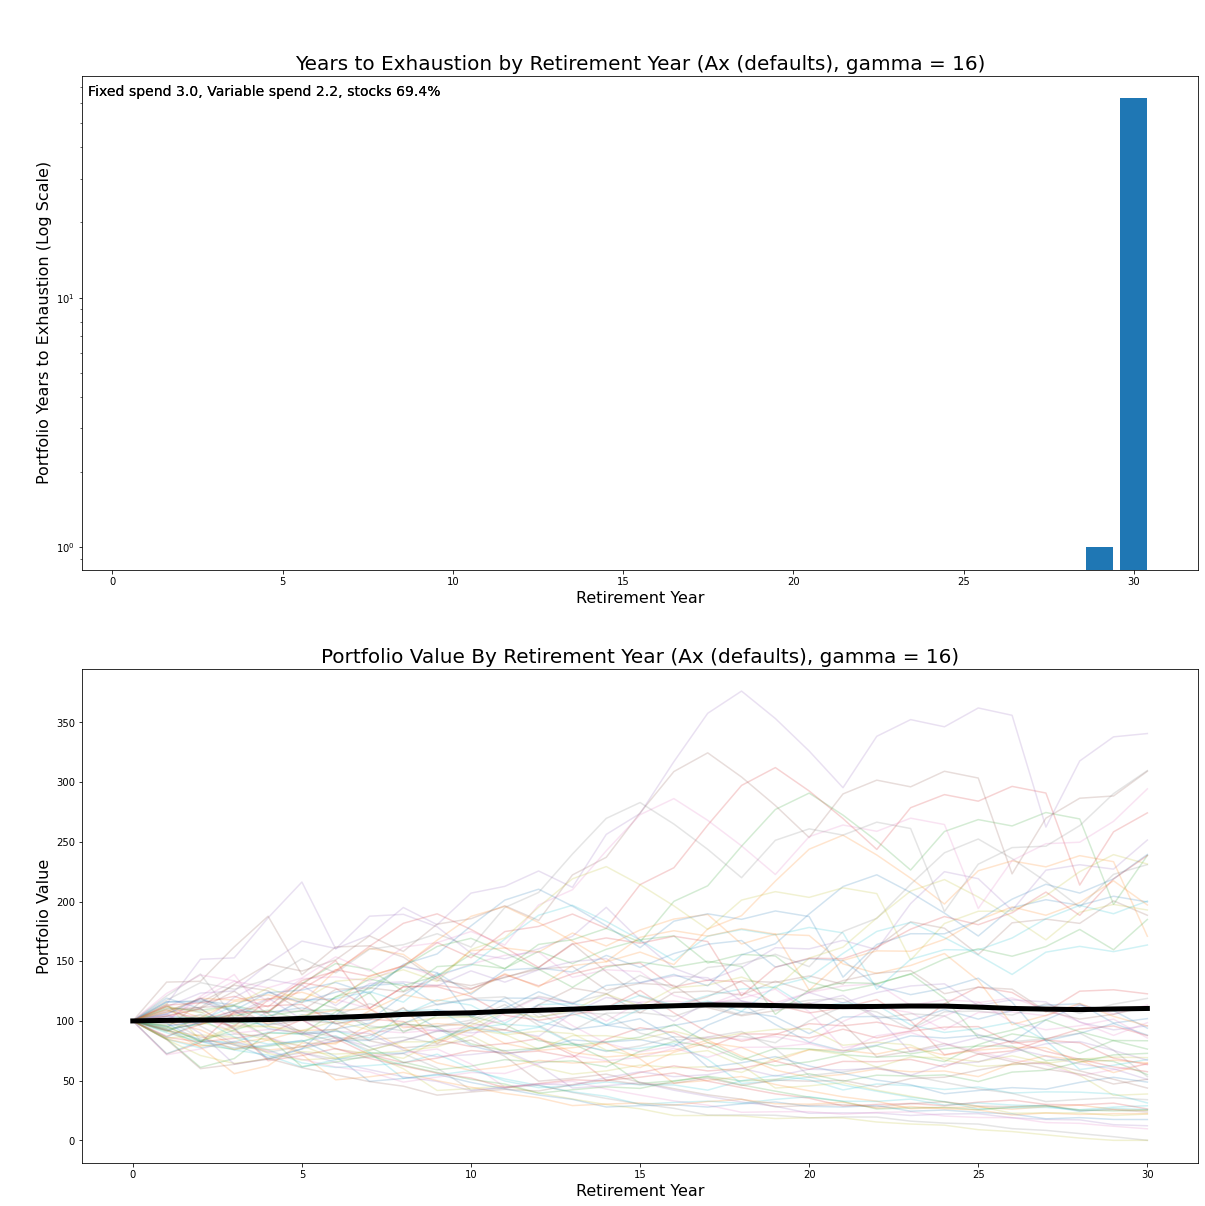

In [34]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True, 
                 'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                 'chart_2' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                }    
})

print(s)

s.simulate()
s.analyze()

In [68]:
import dlib
# http://blog.dlib.net/2017/12/a-global-optimization-algorithm-worth.html?m=1
print("%s %s" % ("dlib", dlib.__version__))

n_trials = N_TRIALS
optimizer = "dlib"

study_params = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

def objective_factory(N_RET_YEARS, gamma):
    # partial doesn't work for dlib i.e. objective = partial(ce_experiment, N_RET_YEARS, gamma)
    def objective(fixed_spend, variable_spend, alloc_stocks):
        return ce_experiment(N_RET_YEARS, gamma, fixed_spend, variable_spend, alloc_stocks)
    return objective
    
for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 

    objective = objective_factory(N_RET_YEARS, gamma)

    best = dlib.find_min_global(f=objective, 
                                bound1=[0., 0., 0.],   # lower bounds
                                bound2=[5., 10., 1.],  # variable_spend
                                num_function_calls=n_trials)
    time_elapsed = datetime.now() - start_time 

    study_params.append((best[1], 
                         best[0], 
                        ))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s value %s" % (datestr(), best_values[0]['objective'], best_parameters))




dlib 19.21.1
2021-02-09 17:58:01 Starting dlib, gamma 0, 1000 trials
2021-02-09 18:00:09 Starting dlib, gamma 1, 1000 trials
2021-02-09 18:02:17 Starting dlib, gamma 2, 1000 trials
2021-02-09 18:04:25 Starting dlib, gamma 4, 1000 trials
2021-02-09 18:06:33 Starting dlib, gamma 6, 1000 trials
2021-02-09 18:08:36 Starting dlib, gamma 8, 1000 trials
2021-02-09 18:10:40 Starting dlib, gamma 10, 1000 trials
2021-02-09 18:12:45 Starting dlib, gamma 12, 1000 trials
2021-02-09 18:14:52 Starting dlib, gamma 14, 1000 trials
2021-02-09 18:16:58 Starting dlib, gamma 16, 1000 trials


In [70]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend']]
results['value'] = [s[0] for s in study_params]
results_dict[optimizer] = results.copy()
results

,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value
0,0,1.000000,0.000000,0.000000,6.204088,-15532.416056
1,1,1.000000,0.000000,0.000000,6.331275,-14329.303954
2,2,1.000000,0.000000,0.000000,6.496263,-13132.511625
3,4,1.000000,0.000000,0.000000,6.790911,-11206.793432
4,6,0.784876,0.215124,1.987611,4.955203,-10213.713600
5,8,0.734466,0.265534,1.703488,5.866187,-9577.023299
6,10,0.722960,0.277040,2.816054,2.954073,-9415.926875
7,12,0.716221,0.283779,3.026950,2.447769,-9174.762741
8,14,0.708559,0.291441,3.093699,2.232305,-8992.384326
9,16,0.700356,0.299644,2.974671,2.322781,-8855.534067


In [71]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


-14329.303953961264

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7f847efa6350>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 2.9746710417705446, 'variable_pct': 2.3227807291189397}
mean annual spending over all cohorts 5.62
0.00% of portfolios exhausted by final year


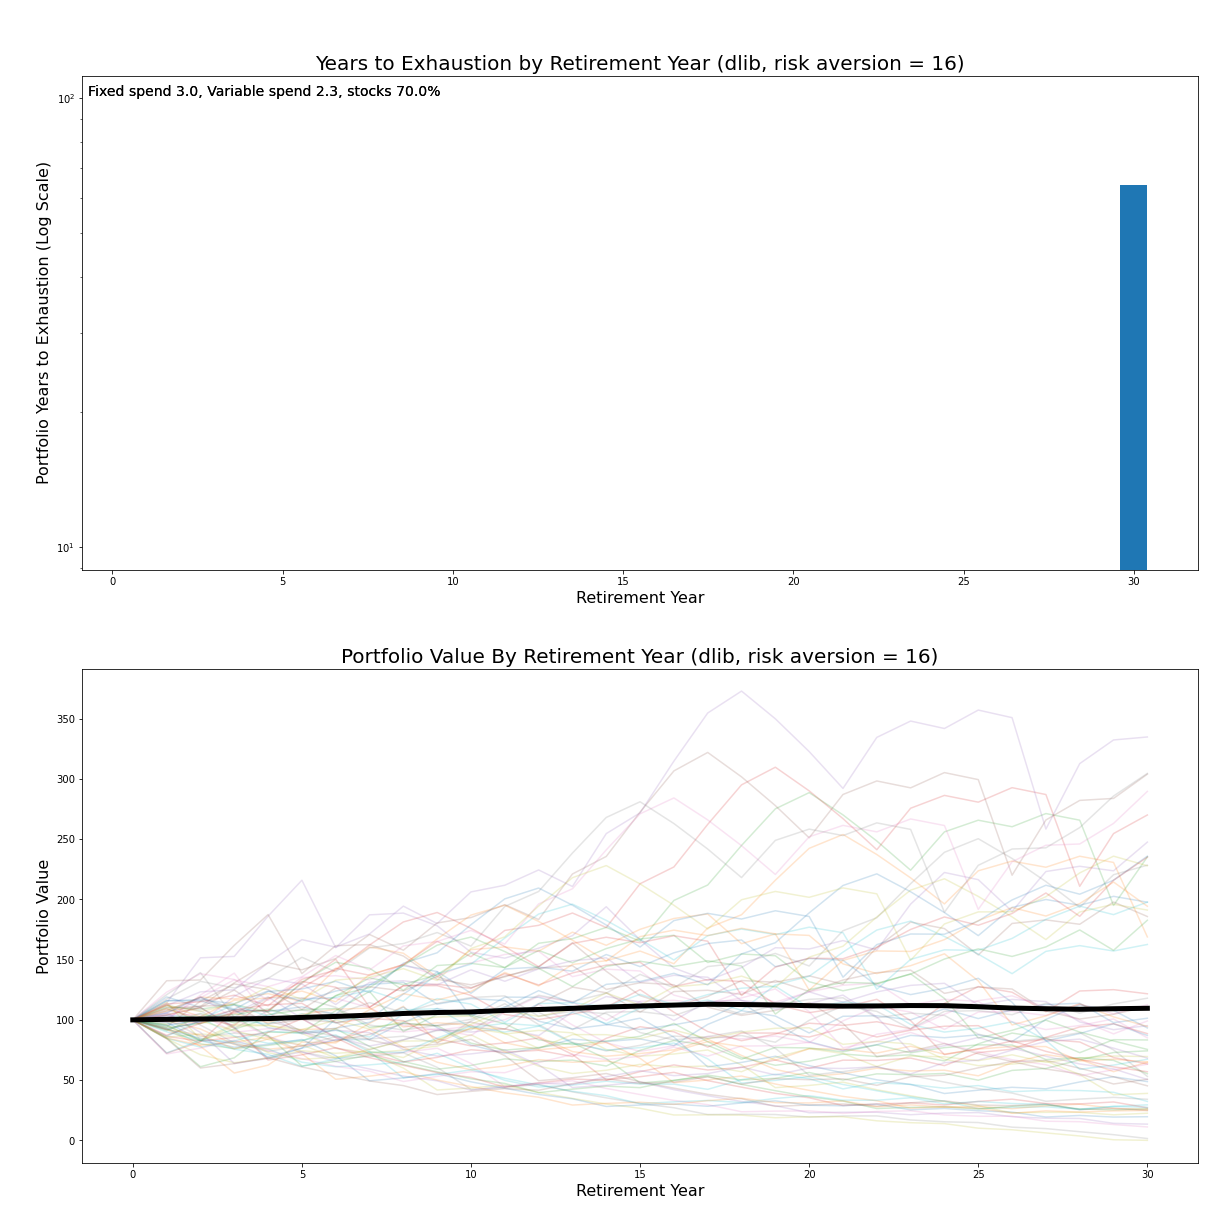

In [72]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True, 
                 'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                 'chart_2' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, resultsrow['gamma']),
                              'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (resultsrow['fixed_spend'], 
                                                                                                      resultsrow['variable_spend'], 
                                                                                                      100 * resultsrow['alloc_stocks'])
                             },
                }    
})

print(s)

s.simulate()
s.analyze()

In [73]:
# from scipy.optimize import basinhopping
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html
# slow and performs poorly
# gamma = 1
# x0 = np.array([1.0, 5.0, 0.5])
# optimizer = "basinhopping"

# stepsize = 0.25
# T = 50
# minimizer_kwargs = {"method": "BFGS"}
# MAX_ITER = 100

# def print_fun(x, f, accepted):
#     print("%s at minimum %.4f accepted %d (%s)" % (datestr(), f, int(accepted), x))
        
# class MyBounds(object):
#     def __init__(self, 
#                  xmax=[5.0, 10.0, 1.0], 
#                  xmin=[0.0,  0.0, 0.0] ):
#         self.xmax = np.array(xmax)
#         self.xmin = np.array(xmin)
#     def __call__(self, **kwargs):
#         x = kwargs["x_new"]
#         tmax = bool(np.all(x <= self.xmax))
#         tmin = bool(np.all(x >= self.xmin))
#         return tmax and tmin
# mybounds = MyBounds()

# print("%s Starting %s, gamma %d, %d iterations" % (datestr(), optimizer, gamma, MAX_ITER))
# start_time = datetime.now()
# bobjective = partial(ce_experiment, N_RET_YEARS, gamma)
# ret = basinhopping(bobjective, x0, minimizer_kwargs=minimizer_kwargs,
#                    niter=MAX_ITER, stepsize=stepsize, T=T,
#                    accept_test=mybounds,
#                    callback=print_fun)



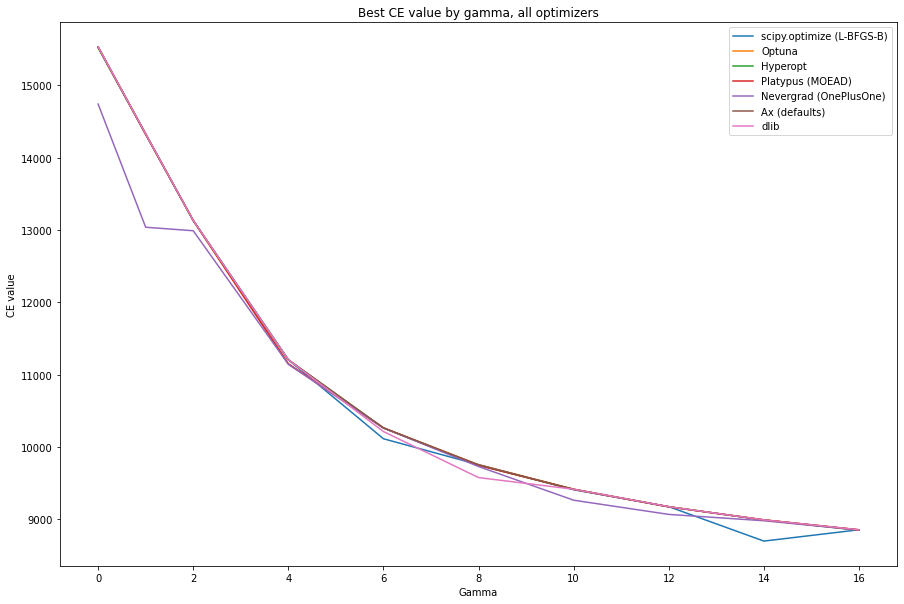

In [74]:
# plot all results
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.title('Best CE value by gamma, all optimizers')
plt.xlabel('Gamma')
plt.ylabel('CE value')
for opt in results_dict.keys():
    plt.plot(results_dict[opt]['gamma'], -results_dict[opt]['value'], label=opt)
    
plt.legend();



In [76]:
results_dict.keys()

dict_keys(['scipy.optimize (L-BFGS-B)', 'Optuna', 'Hyperopt', 'Platypus (MOEAD)', 'Nevergrad (OnePlusOne)', 'Ax (defaults)', 'dlib'])

In [98]:
df_list = []
for optimizer in results_dict.keys():
    results_dict[optimizer]['optimizer'] = optimizer
    df_list.append(results_dict[optimizer])
all_results = pd.concat(df_list)
all_results['value'] = - all_results['value']

In [99]:
all_results['group_gamma_max'] = all_results.groupby(['gamma'])['value'].transform(max)
all_results.loc[all_results['value'] == all_results['group_gamma_max']]

,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value,optimizer,group_gamma_max
0,0,1.000000,0.000000,0.000000,6.204104,15532.416056,scipy.optimize (L-BFGS-B),15532.416056
1,1,1.000000,0.000000,0.000000,6.331374,14329.303955,scipy.optimize (L-BFGS-B),14329.303955
2,2,1.000000,0.000000,0.000000,6.496262,13132.511625,scipy.optimize (L-BFGS-B),13132.511625
3,4,1.000000,0.000000,0.000000,6.790925,11206.793432,scipy.optimize (L-BFGS-B),11206.793432
5,8,0.761725,0.238275,2.741288,3.155909,9755.148796,scipy.optimize (L-BFGS-B),9755.148796
4,6,0.820573,0.179427,2.585221,3.561126,10265.139037,Optuna,10265.139037
6,10,0.733845,0.266155,2.873611,2.825014,9417.177423,Optuna,9417.177423
8,14,0.713015,0.286985,2.920830,2.497363,8992.437983,Optuna,8992.437983
7,12,0.716221,0.283779,3.026950,2.447769,9174.762741,dlib,9174.762741
9,16,0.700356,0.299644,2.974671,2.322781,8855.534067,dlib,8855.534067
